## Visualising DataSet and Importing Library

In [4]:

import numpy as np
import matplotlib.pyplot as plt

import torch
import torchvision
import torch.optim as optim
import torchvision.transforms as transforms

In [2]:
# Downloading and Loading Data Set

transform = transforms.Compose([transforms.ToTensor(),])

trainset = torchvision.datasets.FashionMNIST(root='./data', train=True,download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=32,shuffle=True, num_workers=2)

testset = torchvision.datasets.FashionMNIST(root='./data', train=False,download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=32, shuffle=False, num_workers=2)

classes = ('T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat','Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot')

Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw


Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw


Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw
Processing...
Done!


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


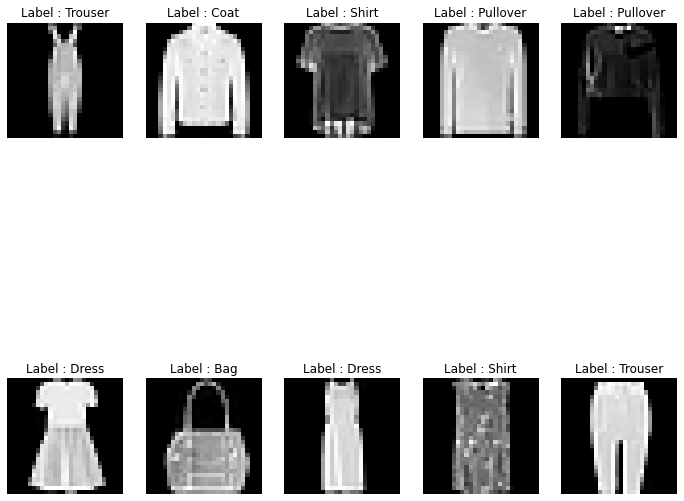

In [5]:
# Visualising 10 random sample from training data
indexes = np.random.randint(0, trainset.data.shape[0], size=10)

plt.figure(figsize=(12, 12))

for i in range(len(indexes)):
    sub = plt.subplot(2, 5, i + 1)
    image = trainset.data[indexes[i]]
    plt.imshow(image, cmap='gray')
    plt.axis('off')
    sub.set_title("Label : " + str(classes[int(trainset.targets[indexes[i]])]))
plt.savefig('Vis.png')
plt.show()

plt.close('all')

In [6]:
trainset.data.shape


torch.Size([60000, 28, 28])

## Defining Model

In [8]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__() 
      
        self.conv1 = nn.Conv2d(1, 6, 3)  # 28x28x1 ---> 26x26x6  

        self.pool = nn.MaxPool2d(2, 2)   # 26x26x6  ---> 13x13x6 

        self.conv2 = nn.Conv2d(6, 8, 3)  #  13x13x6 ---> 11x11x8
        

        self.conv3 = nn.Conv2d(8 , 10, 1) # 11x11x8 ---> 11x11x10

        self.conv4 = nn.Conv2d(10, 12, 1) # 11x11x10 ---> 11x11x12

        self.conv5 = nn.Conv2d(12, 14, 1) # 11x11x12 ---> 11x11x14
        
        self.BatchNorm = nn.BatchNorm2d(14)
        self.conv6 = nn.Conv2d(14, 16, 1) # 11x11x14 ---> 11x11x16
    
        self.fc1 = nn.Linear(16 * 11 * 11, 1024)
        self.fc2 = nn.Linear(1024, 512)
        self.BatchNorm1 = nn.BatchNorm1d(512)
        self.fc3 = nn.Linear(512, 256)
        self.fc4 = nn.Linear(256, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = self.BatchNorm(F.relu(self.conv5(x)))
        x = F.relu(self.conv6(x))

        x = x.view(-1, 16*11*11)
        x = F.relu(self.fc1(x))
        x = self.BatchNorm1(F.relu(self.fc2(x)))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        return x


In [9]:
# Initializing GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

net = Net()
net.to(device)

cuda:0


Net(
  (conv1): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 8, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(8, 10, kernel_size=(1, 1), stride=(1, 1))
  (conv4): Conv2d(10, 12, kernel_size=(1, 1), stride=(1, 1))
  (conv5): Conv2d(12, 14, kernel_size=(1, 1), stride=(1, 1))
  (BatchNorm): BatchNorm2d(14, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv6): Conv2d(14, 16, kernel_size=(1, 1), stride=(1, 1))
  (fc1): Linear(in_features=1936, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=512, bias=True)
  (BatchNorm1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc3): Linear(in_features=512, out_features=256, bias=True)
  (fc4): Linear(in_features=256, out_features=10, bias=True)
)

In [10]:
from torchsummary import summary
summary(net,(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 26, 26]              60
         MaxPool2d-2            [-1, 6, 13, 13]               0
            Conv2d-3            [-1, 8, 11, 11]             440
            Conv2d-4           [-1, 10, 11, 11]              90
            Conv2d-5           [-1, 12, 11, 11]             132
            Conv2d-6           [-1, 14, 11, 11]             182
       BatchNorm2d-7           [-1, 14, 11, 11]              28
            Conv2d-8           [-1, 16, 11, 11]             240
            Linear-9                 [-1, 1024]       1,983,488
           Linear-10                  [-1, 512]         524,800
      BatchNorm1d-11                  [-1, 512]           1,024
           Linear-12                  [-1, 256]         131,328
           Linear-13                   [-1, 10]           2,570
Total params: 2,644,382
Trainable param

## USING SGD

In [11]:
#SGD
learning_rate = [1,0.1,0.01,0.001,0.0001]
Acc_SGD = []
loss_SGD = []
for lrate in learning_rate :

  net = Net()
  net.to(device)

  Acc_V_SGD = []
  loss_V_SGD = []

  criterion = nn.CrossEntropyLoss()
  optimizer = optim.SGD(net.parameters(), lr =lrate, momentum=0.9)

  for epoch in range(10):  # loop over the dataset multiple times

      running_loss = 0.0
      for i, data in enumerate(trainloader, 0):
          # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data[0].to(device), data[1].to(device)

          # zero the parameter gradients
        optimizer.zero_grad()

          # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss = loss.item()
        loss_V_SGD.append(float(running_loss))
  

      correct = 0
      total = 0
      with torch.no_grad():
          for data in testloader:
              images, labels = data[0].to(device), data[1].to(device)
              outputs = net(images)
              _, predicted = torch.max(outputs.data, 1)
              total += labels.size(0)
              correct += (predicted == labels).sum().item()
      
      temp = (100 * correct / total)
      Acc_V_SGD.append(temp)
      print('%d Epoch Complete...'%epoch)
  Acc_SGD.append(Acc_V_SGD)
  loss_SGD.append(loss_V_SGD)
  print('Completed for learning rate '+ str(lrate))

print('Finished Training SGD')

0 Epoch Complete...
1 Epoch Complete...
2 Epoch Complete...
3 Epoch Complete...
4 Epoch Complete...
5 Epoch Complete...
6 Epoch Complete...
7 Epoch Complete...
8 Epoch Complete...
9 Epoch Complete...
Completed for learning rate 1
0 Epoch Complete...
1 Epoch Complete...
2 Epoch Complete...
3 Epoch Complete...
4 Epoch Complete...
5 Epoch Complete...
6 Epoch Complete...
7 Epoch Complete...
8 Epoch Complete...
9 Epoch Complete...
Completed for learning rate 0.1
0 Epoch Complete...
1 Epoch Complete...
2 Epoch Complete...
3 Epoch Complete...
4 Epoch Complete...
5 Epoch Complete...
6 Epoch Complete...
7 Epoch Complete...
8 Epoch Complete...
9 Epoch Complete...
Completed for learning rate 0.01
0 Epoch Complete...
1 Epoch Complete...
2 Epoch Complete...
3 Epoch Complete...
4 Epoch Complete...
5 Epoch Complete...
6 Epoch Complete...
7 Epoch Complete...
8 Epoch Complete...
9 Epoch Complete...
Completed for learning rate 0.001
0 Epoch Complete...
1 Epoch Complete...
2 Epoch Complete...
3 Epoch Com

In [35]:
Acc_SGD

[[10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0],
 [63.98, 71.98, 71.55, 70.78, 74.43, 75.03, 74.49, 77.06, 76.2, 77.62],
 [86.06, 87.88, 88.37, 88.52, 89.76, 89.39, 89.84, 89.46, 89.79, 89.09],
 [86.5, 87.47, 88.12, 88.59, 89.24, 88.88, 88.96, 89.67, 89.41, 89.27],
 [80.58, 84.01, 85.49, 86.71, 87.08, 87.22, 87.67, 88.19, 88.35, 88.55]]

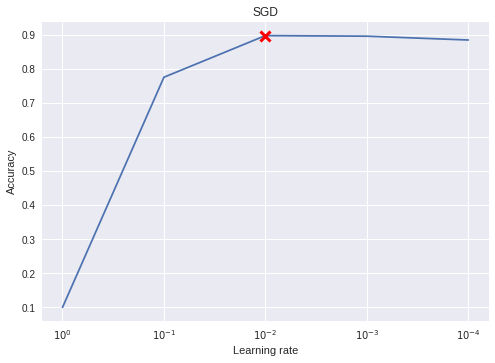

In [34]:
#Plotting result

plt.style.use("seaborn")
plt.xlabel("Learning rate")
plt.ylabel("Accuracy")
plt.title("SGD")
plt.xticks([0,1,2,3,4], ['$10^0$','$10^{-1}$','$10^{-2}$','$10^{-3}$','$10^{-4}$']) 

temp = Acc_SGD
y = (np.max(temp,axis=1)/100).tolist()

p = max(y)
q = y.index(p)

plt.scatter(q,p,marker='x',c='r',s=100,zorder=10,linewidth=3)


x = np.arange(len(y))
plt.plot(x,y)

plt.savefig('./SGD.png')
plt.show()

## Using Adam

In [43]:
#Adam
learning_rate = [1,0.1,0.01,0.001,0.0001]
Acc_Adam = []
loss_Adam = []
for lrate in learning_rate :

  net = Net()
  net.to(device)

  Acc = []
  lss = []

  criterion = nn.CrossEntropyLoss()
  optimizer = optim.Adam(net.parameters(), lr=lrate)

  for epoch in range(10):  # loop over the dataset multiple times

      running_loss = 0.0
      for i, data in enumerate(trainloader, 0):
          # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data[0].to(device), data[1].to(device)

          # zero the parameter gradients
        optimizer.zero_grad()

          # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss = loss.item()
        lss.append(float(running_loss))
  

      correct = 0
      total = 0
      with torch.no_grad():
          for data in testloader:
              images, labels = data[0].to(device), data[1].to(device)
              outputs = net(images)
              _, predicted = torch.max(outputs.data, 1)
              total += labels.size(0)
              correct += (predicted == labels).sum().item()
      
      temp = (100 * correct / total)
      Acc.append(temp)
      print('%d Epoch Complete...'%epoch)
  Acc_Adam.append(Acc)
  loss_Adam.append(lss)
  print('Completed for learning rate '+ str(lrate))

print('Finished Training Adam')

0 Epoch Complete...
1 Epoch Complete...
2 Epoch Complete...
3 Epoch Complete...
4 Epoch Complete...
5 Epoch Complete...
6 Epoch Complete...
7 Epoch Complete...
8 Epoch Complete...
9 Epoch Complete...
Completed for learning rate 1
0 Epoch Complete...
1 Epoch Complete...
2 Epoch Complete...
3 Epoch Complete...
4 Epoch Complete...
5 Epoch Complete...
6 Epoch Complete...
7 Epoch Complete...
8 Epoch Complete...
9 Epoch Complete...
Completed for learning rate 0.1
0 Epoch Complete...
1 Epoch Complete...
2 Epoch Complete...
3 Epoch Complete...
4 Epoch Complete...
5 Epoch Complete...
6 Epoch Complete...
7 Epoch Complete...
8 Epoch Complete...
9 Epoch Complete...
Completed for learning rate 0.01
0 Epoch Complete...
1 Epoch Complete...
2 Epoch Complete...
3 Epoch Complete...
4 Epoch Complete...
5 Epoch Complete...
6 Epoch Complete...
7 Epoch Complete...
8 Epoch Complete...
9 Epoch Complete...
Completed for learning rate 0.001
0 Epoch Complete...
1 Epoch Complete...
2 Epoch Complete...
3 Epoch Com

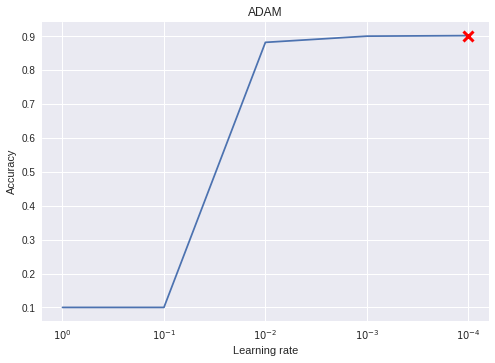

In [48]:
#Plotting result

plt.style.use("seaborn")
plt.xlabel("Learning rate")
plt.ylabel("Accuracy")
plt.title("ADAM")
plt.xticks([0,1,2,3,4], ['$10^0$','$10^{-1}$','$10^{-2}$','$10^{-3}$','$10^{-4}$']) 

temp = Acc_Adam
y = (np.max(temp,axis=1)/100).tolist()

p = max(y)
q = y.index(p)

plt.scatter(q,p,marker='x',c='r',s=100,zorder=10,linewidth=3)


x = np.arange(len(y))
plt.plot(x,y)

plt.savefig('./Adam.png')
plt.show()

## Using Madam

### Defining MADAM Optimizer

In [45]:
import torch
from torch.optim.optimizer import Optimizer, required


class Madam(Optimizer):

    def __init__(self, params, lr=0.01, p_scale=3.0, g_bound=10.0):

        self.p_scale = p_scale
        self.g_bound = g_bound
        defaults = dict(lr=lr)
        super(Madam, self).__init__(params, defaults)

    def step(self, closure=None):
        """Performs a single optimization step.
        Arguments:
            closure (callable, optional): A closure that reevaluates the model
                and returns the loss.
        """
        loss = None
        if closure is not None:
            loss = closure()

        for group in self.param_groups:
            for p in group['params']:
                if p.grad is None:
                    continue

                state = self.state[p]
                if len(state) == 0:
                    state['max'] = self.p_scale*(p*p).mean().sqrt().item()
                    state['step'] = 0
                    state['exp_avg_sq'] = torch.zeros_like(p)

                state['step'] += 1
                bias_correction = 1 - 0.999 ** state['step']
                state['exp_avg_sq'] = 0.999 * state['exp_avg_sq'] + 0.001 * p.grad.data**2
                
                g_normed = p.grad.data / (state['exp_avg_sq']/bias_correction).sqrt()
                g_normed[torch.isnan(g_normed)] = 0
                g_normed.clamp_(-self.g_bound, self.g_bound)
                
                p.data *= torch.exp( -group['lr']*g_normed*torch.sign(p.data) )
                p.data.clamp_(-state['max'], state['max'])

        return loss


### Driver Code for MADAM

In [46]:
learning_rate = [1,0.1,0.01,0.001,0.0001]
Acc_MADAM = []
loss_MADAM = []
for lrate in learning_rate :

  net = Net()
  net.to(device)

  Acc = []
  lss = []

  criterion = nn.CrossEntropyLoss()
  optimizer = Madam(net.parameters(), lr=lrate, p_scale=3.0, g_bound=10.0)

  for epoch in range(10):  # loop over the dataset multiple times

      running_loss = 0.0
      for i, data in enumerate(trainloader, 0):
          # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data[0].to(device), data[1].to(device)

          # zero the parameter gradients
        optimizer.zero_grad()

          # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss = loss.item()
        lss.append(float(running_loss))
  

      correct = 0
      total = 0
      with torch.no_grad():
          for data in testloader:
              images, labels = data[0].to(device), data[1].to(device)
              outputs = net(images)
              _, predicted = torch.max(outputs.data, 1)
              total += labels.size(0)
              correct += (predicted == labels).sum().item()
      
      temp = (100 * correct / total)
      Acc.append(temp)
      print('%d Epoch Complete...'%epoch)
  Acc_MADAM.append(Acc)
  loss_MADAM.append(lss)
  print('Completed for learning rate '+ str(lrate))

print('Finished Training MADAM')

0 Epoch Complete...
1 Epoch Complete...
2 Epoch Complete...
3 Epoch Complete...
4 Epoch Complete...
5 Epoch Complete...
6 Epoch Complete...
7 Epoch Complete...
8 Epoch Complete...
9 Epoch Complete...
Completed for learning rate 1
0 Epoch Complete...
1 Epoch Complete...
2 Epoch Complete...
3 Epoch Complete...
4 Epoch Complete...
5 Epoch Complete...
6 Epoch Complete...
7 Epoch Complete...
8 Epoch Complete...
9 Epoch Complete...
Completed for learning rate 0.1
0 Epoch Complete...
1 Epoch Complete...
2 Epoch Complete...
3 Epoch Complete...
4 Epoch Complete...
5 Epoch Complete...
6 Epoch Complete...
7 Epoch Complete...
8 Epoch Complete...
9 Epoch Complete...
Completed for learning rate 0.01
0 Epoch Complete...
1 Epoch Complete...
2 Epoch Complete...
3 Epoch Complete...
4 Epoch Complete...
5 Epoch Complete...
6 Epoch Complete...
7 Epoch Complete...
8 Epoch Complete...
9 Epoch Complete...
Completed for learning rate 0.001
0 Epoch Complete...
1 Epoch Complete...
2 Epoch Complete...
3 Epoch Com

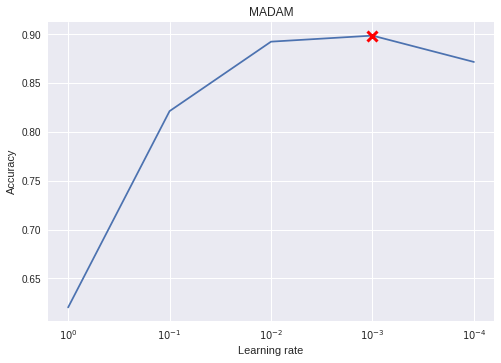

In [47]:
#Plotting result

plt.style.use("seaborn")
plt.xlabel("Learning rate")
plt.ylabel("Accuracy")
plt.title("MADAM")
plt.xticks([0,1,2,3,4], ['$10^0$','$10^{-1}$','$10^{-2}$','$10^{-3}$','$10^{-4}$']) 

temp = Acc_MADAM
y = (np.max(temp,axis=1)/100).tolist()

p = max(y)
q = y.index(p)

plt.scatter(q,p,marker='x',c='r',s=100,zorder=10,linewidth=3)


x = np.arange(len(y))
plt.plot(x,y)

plt.savefig('./MADAM.png')
plt.show()

In [ ]:
#Plotting result

plt.style.use("seaborn")
plt.xlabel("Learning rate")
plt.ylabel("Accuracy")
plt.title("MADAM")
plt.xticks([0,1,2,3,4], ['$10^0$','$10^{-1}$','$10^{-2}$','$10^{-3}$','$10^{-4}$']) 

temp = Acc_MADAM
y = (np.max(temp,axis=1)/100).tolist()

p = max(y)
q = y.index(p)

plt.scatter(q,p,marker='x',c='r',s=100,zorder=10,linewidth=3)


x = np.arange(len(y))
plt.plot(x,y)

plt.savefig('./MADAM.png')
plt.show()

In [66]:
for i in loss_MADAM:
  temp = np.array(i)
  temp = temp.reshape(-1,1875,10)
  print(temp.shape)
  mn= np.mean(temp,axis=1)
  print(mn)
  print(mn.shape)

(1, 1875, 10)
[[1.36548264 1.36485924 1.37432008 1.36445287 1.3640275  1.37268359
  1.36321321 1.35631774 1.35868681 1.36637406]]
(1, 10)


## Combined Comparision

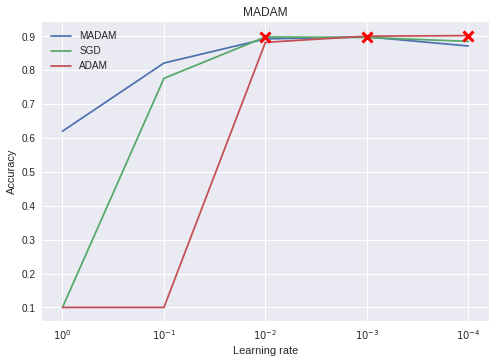

In [50]:
plt.style.use("seaborn")
plt.xlabel("Learning rate")
plt.ylabel("Accuracy")
plt.title("MADAM")
plt.xticks([0,1,2,3,4], ['$10^0$','$10^{-1}$','$10^{-2}$','$10^{-3}$','$10^{-4}$']) 

temp = Acc_MADAM
y = (np.max(temp,axis=1)/100).tolist()
p = max(y)
q = y.index(p)
plt.scatter(q,p,marker='x',c='r',s=100,zorder=10,linewidth=3)

x = np.arange(len(y))
plt.plot(x,y,label = "MADAM")

temp = Acc_SGD
y = (np.max(temp,axis=1)/100).tolist()
p = max(y)
q = y.index(p)
plt.scatter(q,p,marker='x',c='r',s=100,zorder=10,linewidth=3)

x = np.arange(len(y))
plt.plot(x,y,label = "SGD")


temp = Acc_Adam
y = (np.max(temp,axis=1)/100).tolist()
p = max(y)
q = y.index(p)
plt.scatter(q,p,marker='x',c='r',s=100,zorder=10,linewidth=3)

x = np.arange(len(y))
plt.plot(x,y,label = "ADAM")

plt.legend()


plt.savefig('./Comparision.png')
plt.show()

In [5]:
np.save('FMNIST_Acc_MADAM.npy',Acc_MADAM)
np.save('FMNIST_Acc_SGD.npy',Acc_SGD)
np.save('FMNIST_Acc_ADAM.npy',Acc_Adam)